In [21]:
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations


def load_permutations(filename="preferences.csv"):
    """
    Load all student permutations from a file

    Parameters
    ----------
    filename: string
        Path to a file
    
    Returns
    -------
    stars: A list of stars in alphabetical order
    raters: dictionary( 
        string (Ranker's name): list (This person's permutation as a list of numbers
                                      corresponding to the indices in stars)
    )
    """
    raters = {}
    fin = open(filename)
    lines = fin.readlines()
    fin.close()
    stars = [s.rstrip().replace("\"", "") for s in lines[0].split(",")[1::]]
    for line in lines[1::]:
        fields = line.split(",")
        rater = fields[0].replace("\"", "")
        fields = [int(f) for f in fields[1::]]
        raters[rater] = [0]*len(fields)
        for i, x in enumerate(fields):
            raters[rater][x-1] = i
    return stars, raters


def mds(D):
    """
    Perform classic multidimensional scaling
    See notes here:
    http://www.cs.umd.edu/~djacobs/CMSC828/MDSexplain.pdf

    Parameters
    ----------
    D: ndarray(N, N)
        A matrix of pairwise similarities
    
    Return
    ------
    Y: ndarray(N, N)
        MDS projection, with columns in order of variance
        explained
    """
    from numpy import linalg
    N = D.shape[0]
    H = np.eye(N) - np.ones((N, N))/N
    B = -0.5*(H.dot((D*D).dot(H)))
    U, s, V = linalg.svd(B)
    Y = np.sqrt(s[None, :])*U
    return Y

def plot_mds_distances(raters, random_state=0):
    """
    Compute all pairwise Kendall-Tau distances and plot a dimension 
    reduction from the Kendall-Tau metric space to 2D to visualize how
    similar different raters are

    Parameters
    ----------
    raters: dictionary 
        string (Ranker's name): list (This person's permutation as a list of numbers
                                      corresponding to the indices in animals)
    random_state: int
        A seed to determine which random isometry to use for MDS
    """
    N = len(raters)
    D = np.zeros((N, N))
    rlist = [r for r in raters]
    for i, rater1 in enumerate(rlist):
        for j in range(i+1, N):
            rater2 = rlist[j]
            D[i, j] = kendall_tau(raters[rater1], raters[rater2])
    D = D+D.T
    X = mds(D)
    plt.scatter(X[:, 0], X[:, 1])
    for i, r in enumerate(rlist):
        plt.text(X[i, 0], X[i, 1], r)
    plt.title("MDS Projected Kendall-Tau Distances")


def kendall_tau(p1, p2):
    """
    An O(N^2) algorithm for computing the Kendall-Tau Distance

    Parameters
    ----------
    p1: List of N elements
        A permutation of the elements 0, 1, 2, ..., N-1 corresponding 
        to the first rating
    p2: List of N elements
        A permutation of the elements 0, 1, 2, .., N-1 corresponding to 
        the second rating
    
    Returns
    -------
    The Kendall-Tau distance between permutation p1 and p2
    """
    n = len(p1)
    discordant = 0
    indecies1 = []
    indecies2 = []

    #pre-processing 
    for i in range(n):
       indecies1.append(p1.index(i))
       indecies2.append(p2.index(i))

    for i in range(0, n):
        
        for j in range(i+1, n):

            if (indecies1[i] > indecies1[j] and indecies2[i] > indecies2[j]) or (indecies1[i] < indecies1[j] and indecies2[i] < indecies2[j]):
                pass
            else:
                discordant += 1
    return discordant ## TODO: This is a dummy value!


## TODO: Fill everything else in!
def get_diameter(rankings):
    p1 = ""
    p2 = ""
    maxdist = 0
    keys = list(rankings.keys())
    lenk = len(keys)
    for i in range(lenk):
        for j in range(i+1, lenk):
            kt = kendall_tau(rankings[keys[i]], rankings[keys[j]])
            if kt > maxdist:
                maxdist = kt
                p1 = keys[i]
                p2 = keys[j]

    return p1, rankings[p1], p2, rankings[p2], maxdist

def get_average_ranking(stars, raters):
    sums = {}#np.zeros(len(stars))
    keys = list(raters.keys())
    for star in stars:
        sums[star] = 0


    for key in keys:
        for i in range(len(stars)):
            sums[stars[i]] += raters[key].index(i) + 1
        
    for i in range(len(sums)):
        sums[stars[i]] /= len(keys)
    
    res = dict(sorted(sums.items(), key=lambda x:x[1]))
    print(list(res.keys()))

def kendal_tau_fast(p1, p2):
    indecies = []
    for i in range(len(p1)):
        indecies.append(p1.index(i))

    new = []
    for i in range(len(p2)):
        p2[i] = indecies[p2[i]]

    y = [0]*len(p2)
    return mergesort_rec(p2, y, 0, len(p2)-1)

def kemeny(raters):
    stars = [0,1,2,3,4,5,6,7]
    perms = list(permutations(stars))
    
    keys = raters.keys()
    
    best = []
    
    m = 10000000
    
    for perm in perms:
        d = 0
        for key in keys:
            d += kendal_tau_fast(list(perm), raters[key])
        if d < m:
            m = d
            best = perm
            
    return best 
    
    
def merge(x, y, i1, mid, i2):
    """
    Perform a merge of two contiguous sorted sub-chunks of
    the array x, using y as a staging area

    Parameters
    ----------
    x: list
        The main array
    y: list
        The array to copy into as the two chunks are being merged
    i1: int
        Left of first chunk
    mid: int
        Right of first chunk
    i2: int
        End of second chunk
    """
    cursorL = i1
    cursorR = mid + 1
    idx = i1
    swaps = 0

    while cursorL <= mid and cursorR <= i2:
        if x[cursorL] <= x[cursorR]:
            y[idx] = x[cursorL]
            idx += 1
            cursorL += 1
        elif x[cursorR] < x[cursorL]:
            y[idx] = x[cursorR]
            idx += 1
            cursorR += 1
            swaps += mid - cursorL + 1

    while cursorL <= mid:
        y[idx] = x[cursorL]
        idx += 1
        cursorL += 1

    while cursorR <= i2:
        y[idx] = x[cursorR]
        idx += 1
        cursorR += 1
   
    for i in range(i1, i2 + 1):
        x[i] = y[i]
    
    return swaps

def mergesort_rec(x, y, i1, i2):
    """
    A recursive call to sort a subset of the array

    Parameters
    ----------
    x: list
        Array to sort
    y: list
        A temporary array / staging area to store intermediate results
    i1: int
        First index of chunk to sort, inclusive
    i2: int
        Second index of chunk to sort, inclusive (i2 >= i1)
    """
    ret = 0
    if i1 < i2:
        mid = i1 + (i2 - i1) // 2
        ## TODO: Fill this in
        left = mergesort_rec(x, y, i1, mid)
        right = mergesort_rec(x, y, mid + 1, i2)
        merge_result = merge(x, y, i1, mid, i2) 
        ret = left + right + merge_result
    return ret 

def compare_cover_songs(Songs):
    g = np.zeros((32, 32))
    for i in range(len(Songs) - 1):
        for j in range(i + i, len(Songs) - 1):
            d =  kendal_tau_fast(Songs[i]["rankings"], Songs[j]["rankings"])
            g[i][j] = d 
            g[j][i] = d 
    return g



def plot_tune_similarities(tunes, D):
    """
    Parameters
    ----------
    tunes: list of N dictionary items
        Tunes loaded in from the JSON file
    D: ndarray(N, N)
        An NxN matrix with the Kendall-Tau distances between
        all pairs of tunes
    """
    pix = np.arange(len(tunes))
    J, I = np.meshgrid(pix, pix)
    J = J.flatten()
    I = I.flatten()
    sz = np.max(D)-D
    sz /= np.max(sz)
    sz = sz**1.5
    sz = 40*sz/np.max(sz)
 
    plt.figure(figsize=(12, 10))
    plt.scatter(J, I, s=sz, c=D, cmap='magma')
    plt.gca().invert_yaxis()
    plt.xticks(np.arange(D.shape[0]), [t["name"] + " " + t["version"] for t in tunes], rotation=90)
    plt.yticks(np.arange(D.shape[0]), [t["name"] + " " + t["version"] for t in tunes])
    plt.colorbar()
    plt.gca().set_facecolor((0.9, 0.9, 0.9))
    


In [25]:
stars, raters = load_permutations()
print(stars)

keys = list(raters.keys())
for i in range(len(keys) - 1):
    print(raters[keys[i]],raters[keys[i+1]])
    print(kendall_tau(raters[keys[i]],raters[keys[i + 1]]))
    print(kendal_tau_fast(raters[keys[i ]],raters[keys[i + 1]]))

['Taylor Swift', 'Drake', 'Dua Lipa', 'Miley Cyrus', 'Michael Jackson', 'Nirvana', 'The Beatles', 'Journey']
[2, 7, 4, 0, 6, 3, 5, 1] [0, 2, 4, 5, 6, 7, 3, 1]
8
8
[0, 1, 2, 3, 4, 5, 6, 7] [0, 2, 4, 5, 6, 7, 3, 1]
10
10
[0, 1, 2, 3, 4, 5, 6, 7] [5, 6, 7, 4, 3, 0, 2, 1]
23
23
[0, 1, 2, 3, 4, 5, 6, 7] [2, 4, 7, 5, 1, 6, 0, 3]
16
16
[0, 1, 2, 3, 4, 5, 6, 7] [0, 6, 5, 3, 2, 1, 4, 7]
12
12
[0, 1, 2, 3, 4, 5, 6, 7] [4, 6, 0, 1, 5, 7, 3, 2]
14
14
[0, 1, 2, 3, 4, 5, 6, 7] [5, 1, 7, 6, 4, 2, 3, 0]
20
20
[0, 1, 2, 3, 4, 5, 6, 7] [4, 5, 0, 3, 1, 6, 2, 7]
11
11
[0, 1, 2, 3, 4, 5, 6, 7] [6, 5, 4, 7, 1, 3, 2, 0]
23
23
[0, 1, 2, 3, 4, 5, 6, 7] [0, 6, 5, 4, 7, 3, 1, 2]
17
17
[0, 1, 2, 3, 4, 5, 6, 7] [1, 5, 4, 6, 7, 2, 3, 0]
16
16
[0, 1, 2, 3, 4, 5, 6, 7] [0, 3, 2, 4, 5, 7, 6, 1]
8
8
[0, 1, 2, 3, 4, 5, 6, 7] [4, 1, 6, 7, 5, 0, 2, 3]
16
16
[0, 1, 2, 3, 4, 5, 6, 7] [1, 0, 2, 3, 4, 7, 5, 6]
3
3
[0, 1, 2, 3, 4, 5, 6, 7] [1, 6, 4, 0, 2, 5, 7, 3]
11
11
[0, 1, 2, 3, 4, 5, 6, 7] [4, 2, 0, 1, 6, 5, 7, 3]
10
10
[

[[       0. 56116444. 56129743. ... 55903197. 55855687.        0.]
 [56116444.        0.        0. ...        0.        0.        0.]
 [56129743.        0.        0. ...        0.        0.        0.]
 ...
 [55903197.        0.        0. ...        0.        0.        0.]
 [55855687.        0.        0. ...        0.        0.        0.]
 [       0.        0.        0. ...        0.        0.        0.]]


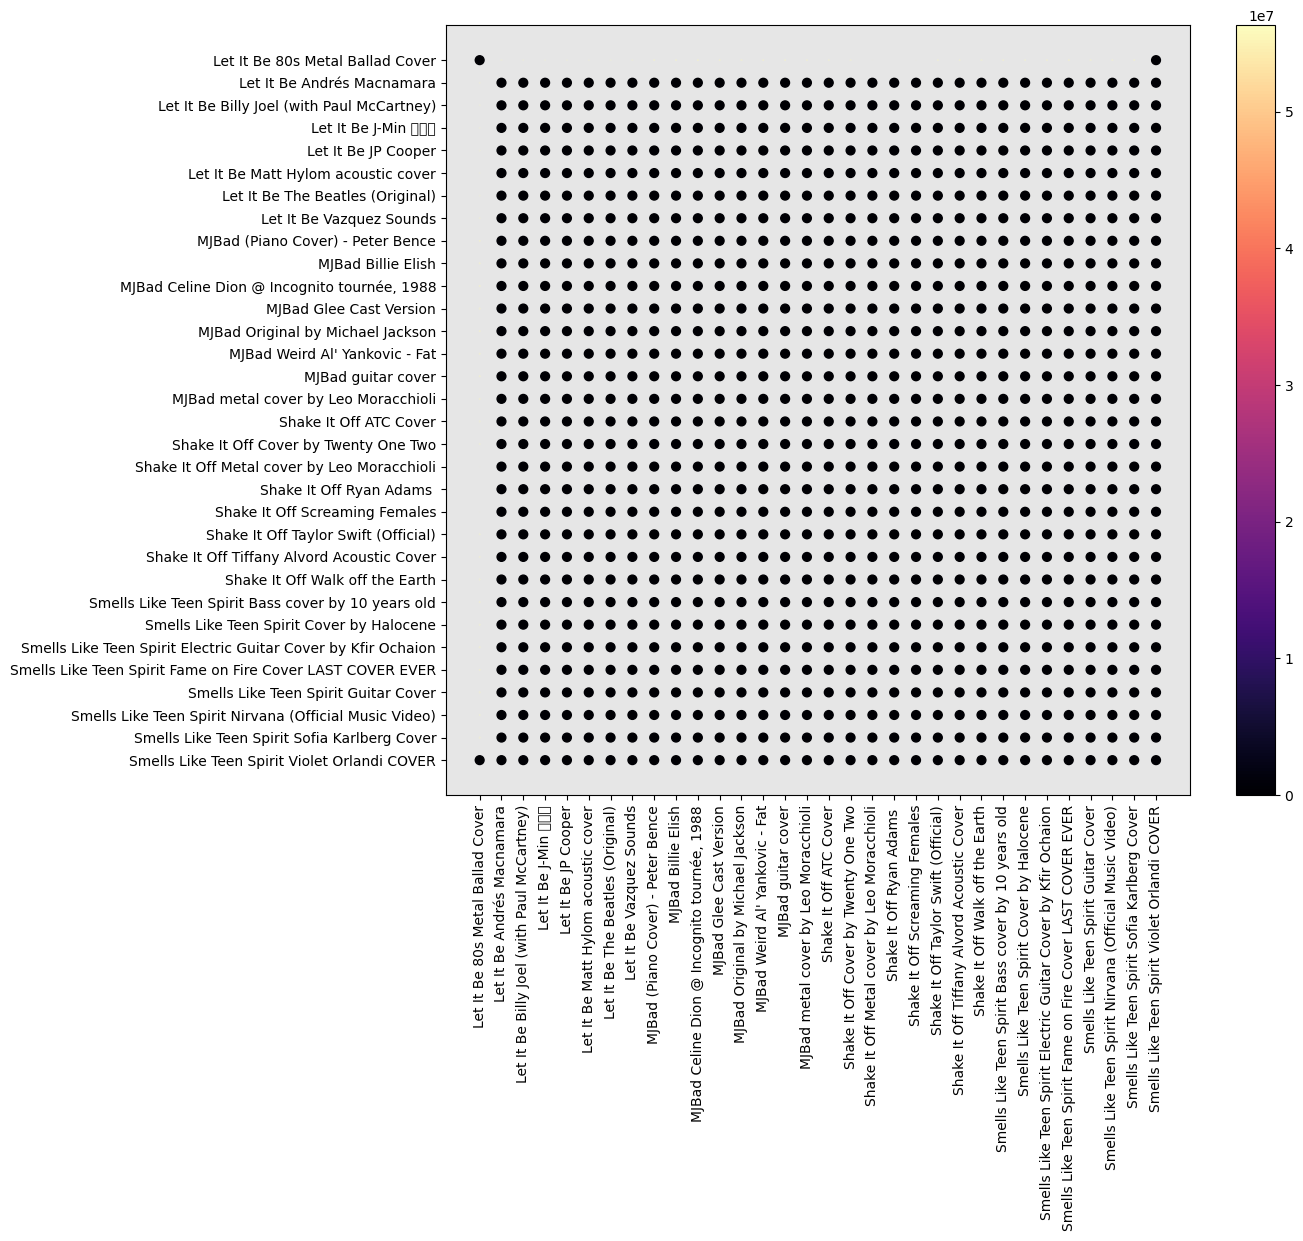

In [23]:
tunes = json.load(open("tunes.json", encoding="utf8"))
D = compare_cover_songs(tunes)
print(D)
plot_tune_similarities(tunes, D)